# UNICEF Ghana: Handwashing with Ananse

Taking a look at time distributions of the video data

[Project Homepage](https://www.unicef.org/ghana/communication_10253.html)

[GitHub Repository - add link](add link)


** Tested for Mac, probably works with other Unix-based systems as well**

First I performed some very basic cleaning of the directories:
- Tried to standardize the spacing in file names
- Fixed outlier errors in naming conventions for some entries
- Added some empty directories where missing (Video 2) to make directory path error checking more straight forward

## 1: Importing Libraries and Data

In [156]:
# imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
import seaborn as sns
import os
import os.path, time
import sys
%matplotlib inline
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

In [3]:
# list top directories
schools = [f for f in os.listdir('/Volumes/GhanaSorted/') if f[0]!='.']
numSchools = len(schools)
print("School Names:",*schools, sep='\n')

School Names:
Agona Nkran Islamic
Akakom DA Primary
Akropong Presby Primary
Akwaboso Methodist Primary
Ampampatia
Asafo Presby Primary
Asamama Presby Primary
Awutu AME Zion
Ayinam Presby Primary
Gyesikrom AEDA Primary
Itifaqiya Islamic Primary
Kwabeng Anglican Primary
Mankrong Methodist Primary
Ninta Methodist
Nsabaa AME Zion
Nsabaa Methodist
Nuriya DA Primary Bawijiase
Presby Primary Bawijiase
Rev. Erickson
St. Killian Catholic Primary


## 2: Extracting the Timestamps

According to stackoverflow, retrieving file creation dates turns out to be platform-dependent.   
Testing this with Mac, although it may work with other Unix-based systems.  

In [74]:
# List of all video file paths in each school's Video/Video 1 and Video/Video 2 folders
vidPaths = ['/Volumes/GhanaSorted/'+s+'/Baseline/Video/Video 1/' for s in schools] 
vidPaths += ['/Volumes/GhanaSorted/'+s+'/Baseline/Video/Video 2/' for s in schools]

# convert school names to proper linux directory paths (might need later)
escapedTopVidDirs = ['/Volumes/GhanaSorted/'+s.replace(' ', r'\ ')+'/Baseline/Video/' for s in schools]
# escaped list of paths for 'Video 1' and 'Video 2' (also may need later)
escapedBothVidDirs = [e+'Video\\ 1/' for e in escapedTopVidDirs] + [e+'Video\\ 2/' for e in escapedTopVidDirs]

# Create large list of full file paths for each video in each school's Video 1 and Video 2 directories
vidFullPaths = [f+v for f in vidPaths for v in os.listdir(f) if v[0]!='.']
vidNum = len(vidFullPaths)
print("Number of total videos in all 'Video 1' and 'Video 2' directories: ", vidNum)

# list(each school) of lists(each vid path) for each 'Video 1' and 'Video 2' dir
v1FullPaths = [[s+v for v in os.listdir(s) if v[0]!='.'] for s in vidPaths[:int(len(vidPaths)/2)]]
v2FullPaths = [[s+v for v in os.listdir(s) if v[0]!='.'] for s in vidPaths[int(len(vidPaths)/2):]]
# aggregated above 
bothFullPaths = [v1fullpaths[i]+v2fullpaths[i] for i in range(len(v1fullpaths))] # 16730 total

Number of total videos in all 'Video 1' and 'Video 2' directories:  16730


In [86]:
# list of lists with creation times for all videos in all 'Video 1' and 'Video 2' directories
timestamps = [time.ctime(os.path.getmtime(f)).replace('  ', ' ').split(' ') for f in vidFullPaths]

# list of lists of lists: sTimestamps[school][timestamp][section of timestamp]
sTimestamps = [ [time.ctime(os.path.getmtime(v)).replace('  ', ' ').split(' ') for v in school] for school in bothFullPaths] 

# example of first 10 videos and corresponding timestamps
print("Example of full file paths and creation dates for the first five videos:\n")
for i in range(5):
    print('path:\t    ' + vidFullPaths[i],'\ntimestamp: ',timestamps[i],'\n')

Example of full file paths and creation dates for the first five videos:

path:	    /Volumes/GhanaSorted/Agona Nkran Islamic/Baseline/Video/Video 1/VID0001.AVI 
timestamp:  ['Tue', 'Feb', '7', '10:06:30', '2017'] 

path:	    /Volumes/GhanaSorted/Agona Nkran Islamic/Baseline/Video/Video 1/VID0002.AVI 
timestamp:  ['Tue', 'Feb', '7', '10:07:06', '2017'] 

path:	    /Volumes/GhanaSorted/Agona Nkran Islamic/Baseline/Video/Video 1/VID0003.AVI 
timestamp:  ['Tue', 'Feb', '7', '10:07:40', '2017'] 

path:	    /Volumes/GhanaSorted/Agona Nkran Islamic/Baseline/Video/Video 1/VID0004.AVI 
timestamp:  ['Tue', 'Feb', '7', '10:12:36', '2017'] 

path:	    /Volumes/GhanaSorted/Agona Nkran Islamic/Baseline/Video/Video 1/VID0005.AVI 
timestamp:  ['Tue', 'Feb', '7', '10:13:24', '2017'] 



## 3: Visualizing the Data

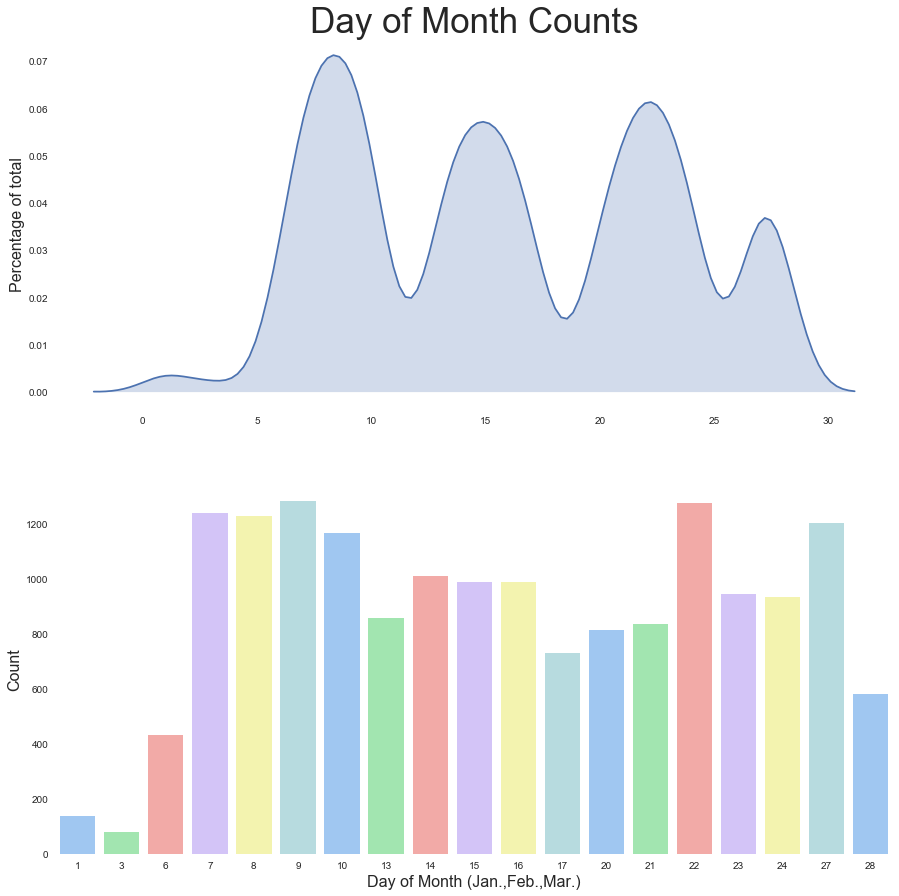

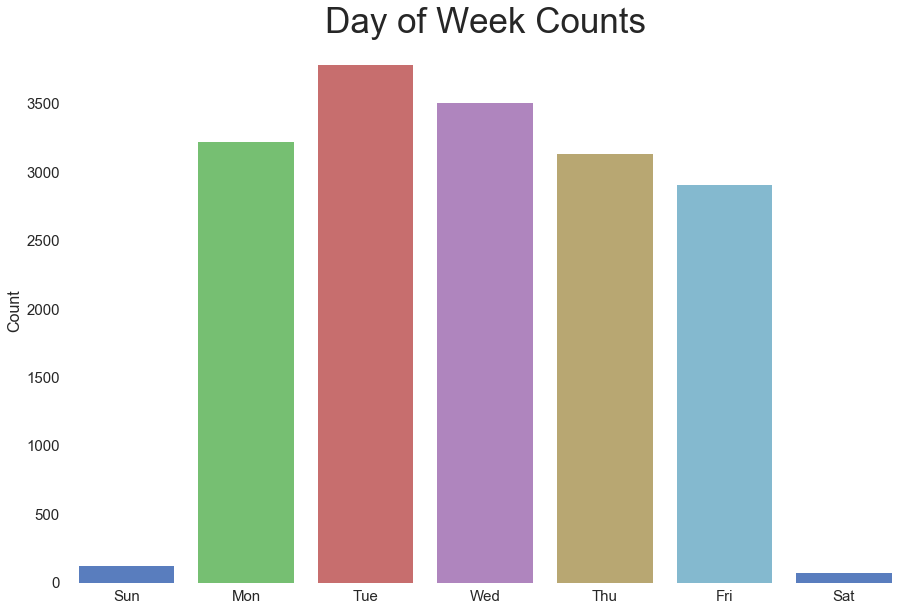

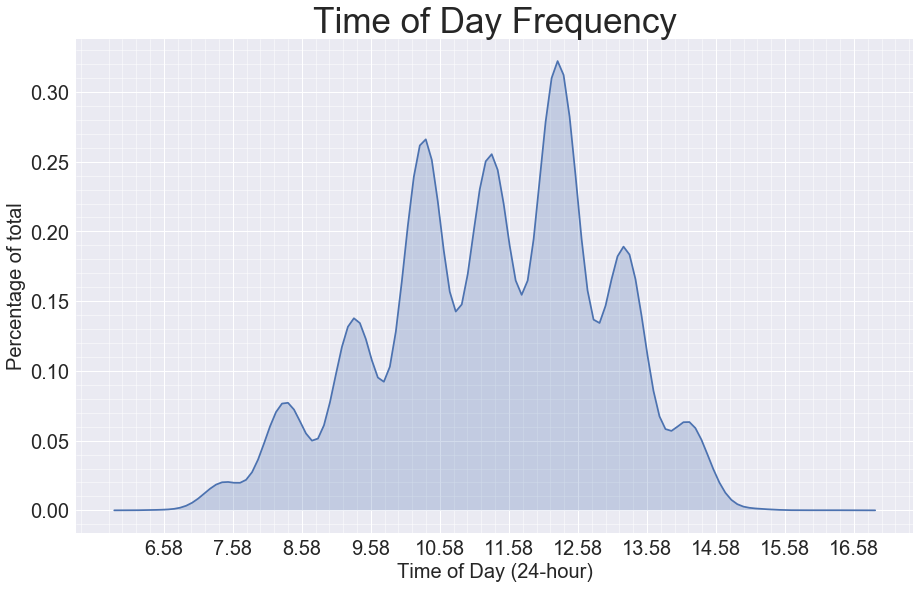

In [238]:
# Day of the month
figDayMonth = plt.figure(figsize=(15,15))
# kernel density estimate
sns.set_style("white")
ax1 = figDayMonth.add_subplot(2,1,1)
dayMonth = [int(d[2]) for d in timestamps]
ax1 = sns.kdeplot(np.asarray(dayMonth), shade='True')
sns.despine(left=True, bottom=True)
ax1.set_ylabel('Percentage of total', FontSize='16')
ax1.set_title('Day of Month Counts', FontSize=35)
# bar
ax2 = figDayMonth.add_subplot(2,1,2)
ax2 = sns.countplot(x=np.asarray(dayMonth), palette="pastel"); #colorblind
ax2.set_ylabel("Count", FontSize=16)
ax2.set_xlabel("Day of Month (Jan.,Feb.,Mar.)", FontSize=16)
sns.despine(left=True, bottom=True, top=True, right=True)
plt.show()
print(2*'\n')



# Day of the week
figDayWeek = plt.figure(figsize=(15,10))
k = ['Sun','Mon','Tue','Wed','Thu','Fri','Sat']
dayWeek = sorted([d[0] for d in timestamps], key=k.index)
ax = sns.countplot(x=np.asarray(dayWeek), palette="muted");
ax.set_title('Day of Week Counts', FontSize=35)
ax.tick_params(labelsize=15)
ax.set_ylabel("Count", FontSize=16)
sns.despine(left=True, bottom=True, top=True, right=True)
plt.show()
print(2*'\n')

# Times of day
times = [t[3].split(':') for t in timestamps]
times = np.asarray(sorted([float(t[0]+'.'+t[1]+t[2]) for t in times]))
figTimes = plt.figure(figsize=(15,20))
sns.set_style("dark")
ax3 = figTimes.add_subplot(2,1,1)
dayMonth = [int(d[2]) for d in timestamps]
ax3 = sns.kdeplot(times, shade='True')
sns.despine(left=True, bottom=True)
ax3.set_ylabel('Percentage of total', FontSize='20')
ax3.set_title('Time of Day Frequency', FontSize=35)
ax3.tick_params(labelsize=20)
ax3.set_xticks(np.arange(min(times), max(times)+1, 1.0))
ax3.set_xlabel("Time of Day (24-hour)", FontSize=20)
ax3.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax3.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax3.grid(b=True, which='major', color='w', linewidth=1.0)
ax3.grid(b=True, which='minor', color='w', linewidth=0.5)

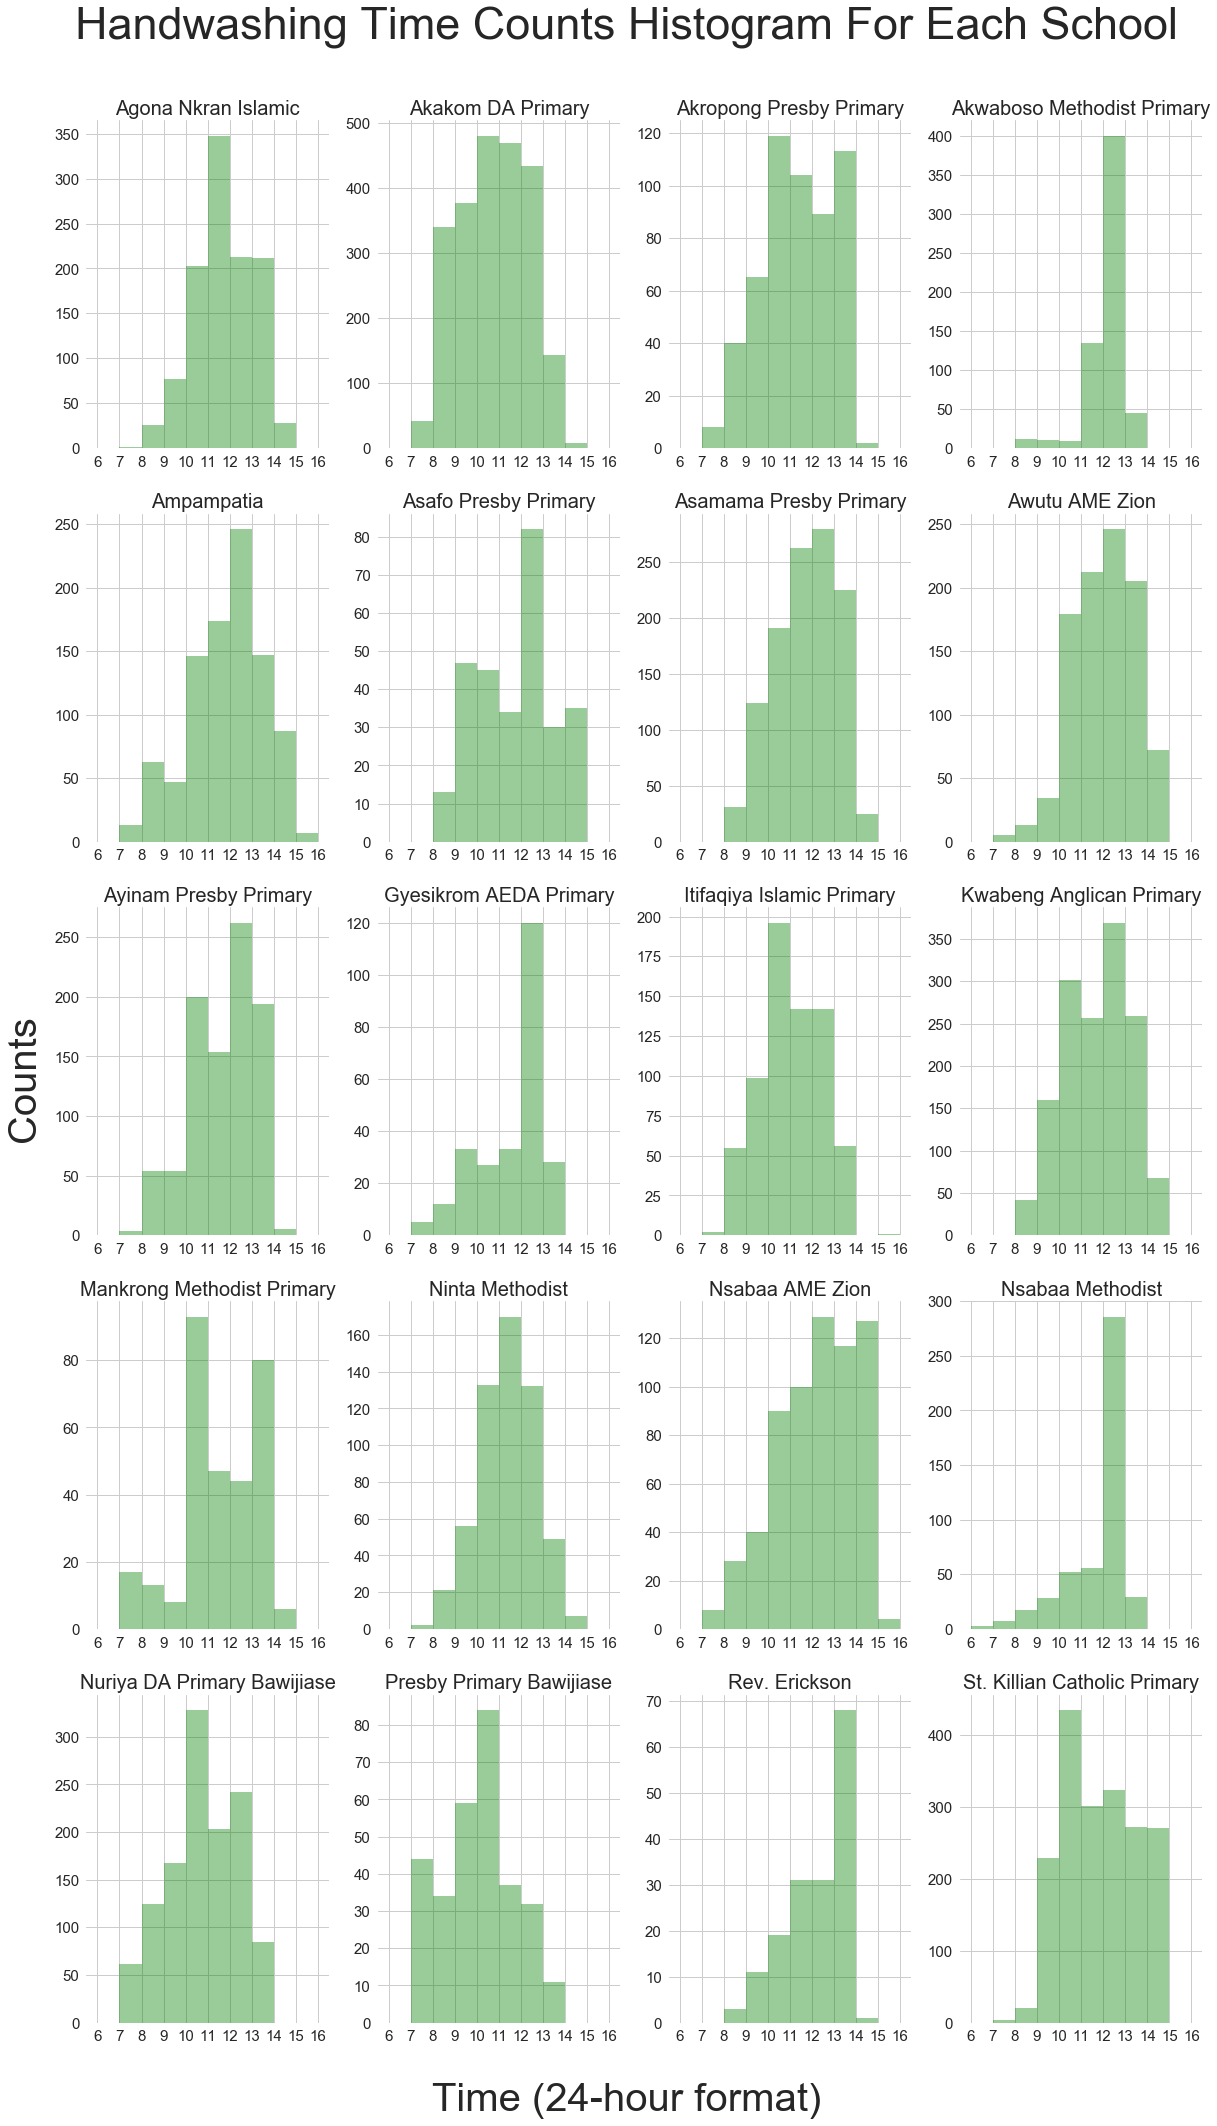

In [274]:
# add some space
print(2*'\n')

# list of list for times grouped by school, converted mins/secs to 0-100 scale
timesBySchool = [[ts[3].split(':') for ts in school] for school in sTimestamps]
timesBySchool = [sorted([float(t[0]+'.'+str(int(float(t[1])*100/60))+str(int(float(t[2])*100/60))) 
                         for t in school]) for school in timesBySchool]
# start and end times for each school, might be helpful later
startTimes = [t[0] for t in timesBySchool]
endTimes = [t[-1] for t in timesBySchool]

sns.set_style("whitegrid")

# create figure
fig = plt.figure(figsize=(20,35))

# histograms iterating over schools
for i, s in enumerate(schools):
    axis = fig.add_subplot(5,4,i+1)
    sns.distplot(timesBySchool[i], kde=False, color='g', ax=axis, bins=np.arange(6,17,1), rug=False);
    axis.set_title(s, FontSize=20)
    sns.despine(left=True,right=True,top=True,bottom=True, ax=axis)
    axis.tick_params(labelsize=15)
    axis.set_xticks(np.arange(6,17,1))

# main title and axis labels
fig.text(0.5, 0.09, 'Time (24-hour format)', ha='center', FontSize=40)
fig.text(0.07, 0.5, 'Counts', va='center', rotation='vertical', FontSize=40)
fig.suptitle('Handwashing Time Counts Histogram For Each School', y=0.925,fontsize=45)
plt.savefig('timestamp_histograms')
plt.show()

In [234]:
# converting to pandas data frame (for convenience)
df = pd.concat([pd.DataFrame(d) for d in sTimestamps], keys=schools)
df.columns = ['Day', 'Month', 'Date', 'Time', 'Year']

df.head(10)

Day Month Date      Time  Year
Agona Nkran Islamic 0  Tue   Feb    7  10:06:30  2017
                    1  Tue   Feb    7  10:07:06  2017
                    2  Tue   Feb    7  10:07:40  2017
                    3  Tue   Feb    7  10:12:36  2017
                    4  Tue   Feb    7  10:13:24  2017
                    5  Tue   Feb    7  10:16:58  2017
                    6  Tue   Feb    7  10:17:30  2017
                    7  Tue   Feb    7  10:24:02  2017
                    8  Tue   Feb    7  11:24:22  2017
                    9  Tue   Feb    7  11:31:22  2017

## 4: Reporting Observations:

- Approx. 10am-1pm is the most active hand-washing period
- time slots 12-1pm and 10-11am are the two most active hour-long periods
- 
